In [1]:
#Import packages
import pandas as pd
pd.set_option('mode.chained_assignment', None)  # Suppress SettingWithCopyWarning
import numpy as np

from functions import plot_cpt_data_NW_site_all, plot_cpt_data_NW_tests
import matplotlib.pyplot as plt

In [2]:
######################## Define the text size of each plot globally ###########
SMALL_SIZE = 9
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
######################## Define the text size of each plot globally ###########

In [3]:
file_path = r"..\\data\sites_invest\silt\HALC11.xlsx"


prefix = r'..\graphics\\'
suffix = r'_test_site_silt_2024.png'
investigated_column =  ['gamma (kN/m3)', 'su (kPa)', 'M (MN/m2)', 'OCR (-)']
investigated_column_plot =  ['$\gamma_{sat}$ (kN/m$^3$)', '$s_u$ (kPa)', 'M (MN/m$^2$)', 'OCR (-)']
save_paths = [prefix + '1_gamma_prediction'+suffix, prefix + '2_su_prediction'+suffix, prefix + '3_M_prediction'+suffix, prefix + '4_OCR_prediction'+suffix]

j = 0
investigated_column_plot = investigated_column_plot[j]
investigated_column = investigated_column[j]
save_path = save_paths[j]


columns_x = ['Depth (m)','qc (MPa)', 'fs (kPa)','Rf (%)'] #for Machine learning features
plot_columns_x_label = ['Depth (m)','$q_c$ (MPa)', '$f_s$ (kPa)','$R_f$ (%)'] #for plotting purpose

columns_x.append(investigated_column)
plot_columns_x_label.append(investigated_column_plot)

# Read the Excel file into a DataFrame
df_test_norway = pd.read_excel(file_path)
df_vs = pd.DataFrame({
    'Depth (m)': df_test_norway['Depth'],
    'vs (m/s)': df_test_norway['Shear wave']
})
df_vs.drop(index=df_vs.index[:2], axis=0, inplace=True)

df_test_norway.drop(index=df_test_norway.index[:2], axis=0, inplace=True)
u2 = np.float64(df_test_norway.iloc[:,3].values)

df_test_norway = df_test_norway.iloc[:, 0:3]  

df_test_norway.columns = ['Depth (m)', 'qc (MPa)', 'fs (kPa)']
df_test_norway.loc[:,'fs (kPa)'] = df_test_norway.loc[:,'fs (kPa)']*1000
df_test_norway.loc[:,'Rf (%)'] = df_test_norway.loc[:,'fs (kPa)']/(df_test_norway.loc[:,'qc (MPa)']*1000)*100

df_test_norway_set = df_test_norway.astype(float)
df_test_norway['fs (kPa)'] = df_test_norway['fs (kPa)'].replace(0, 1e-6)

In [4]:
df_test_norway_set

,Depth (m),qc (MPa),fs (kPa),Rf (%)
2,2.51,0.237,0.01,0.004219
3,2.52,1.141,0.10,0.008764
4,2.53,1.421,0.00,0.000000
5,2.54,1.614,0.00,0.000000
6,2.55,1.737,0.10,0.005757
...,...,...,...,...
1482,17.31,7.279,8.96,0.123094
1483,17.32,12.908,10.30,0.079795
1484,17.33,13.180,10.10,0.076631
1485,17.34,14.003,9.90,0.070699


In [5]:
vs2 = lambda fs: 51.6 * np.log(fs) + 18.5         # Mayne 2006 ... various soil types                # 
vs10 = lambda qc, fs: 12.02 * (qc * 1000) ** 0.319 * (fs) ** (-0.0466)  # Hegazy and Mayne 1995 ... various soil types

gamma_lb = lambda qf, Rf: 19.5 - 2.87 * (np.log10(9000 / qf) / np.log10(20 / Rf)) #... Lengkeek and Brinkgreve (2022)
gamma_t_rc = lambda gamma_w, Rf, q_t, p_a: gamma_w * (0.27 * np.log10(Rf) + 0.36 * np.log10(q_t / p_a) + 1.236) #Robertson and Cabal (2010)

su_1 =lambda qt, u2:(qt - u2)/8
su_2 =lambda qt, sig: (qt - sig) / 12

qc = np.float64(np.array(df_test_norway.loc[:,'qc (MPa)'].values))
qt = np.float64(qc + u2*(1-0.71))

fs = np.float64(np.array(df_test_norway.loc[:,'fs (kPa)'].values))
Rf = np.float64(np.array(df_test_norway.loc[:,'Rf (%)'].values))
Rf = np.where(Rf <= 0, 1e-5, Rf)
z = np.array(pd.to_numeric(df_test_norway['Depth (m)'], errors='coerce'))

## shear wave velocity
vs_2 = vs2(fs)
vs_10 = vs10(qc, fs)

## gamma
gamma_lb = gamma_lb(qt*1000, Rf)
gamma_t_rc = gamma_t_rc(10, Rf, qt*1000, 100)

## undrain shear strength
su_1 = su_1(qt, u2)
su_2 = su_2(qt, z * (gamma_lb+gamma_t_rc)/2 /1000)

In [6]:
import joblib
import glob
import os

pred_dict = {}

for file in sorted(glob.glob(f"*.joblib"), key=os.path.getmtime):
    print(file)
    loaded_model = joblib.load(file)
    y_pred = loaded_model.predict(df_test_norway_set)
    pred_dict[file] = y_pred
    

2_su_prediction_xgb_model.joblib
10_vs_prediction_xgb_model.joblib
1_gamma_prediction_xgb_model.joblib


In [7]:
pred_df = pd.DataFrame(pred_dict)

sorted_columns = sorted(pred_df.columns, key=lambda x: int(x.split('_')[0]))
pred_df = pred_df[sorted_columns]

# pred_df = pred_df.rolling(window=20, axis=0).mean()

pred_df

,1_gamma_prediction_xgb_model.joblib,2_su_prediction_xgb_model.joblib,10_vs_prediction_xgb_model.joblib
0,15.307794,51.158745,162.675888
1,15.865005,119.717194,185.871078
2,15.927146,155.903717,196.524506
3,16.040586,155.903717,187.590027
4,16.040586,155.903717,176.210220
...,...,...,...
1480,17.398623,154.197205,216.948380
1481,17.033543,157.537415,358.416107
1482,17.064903,157.537415,358.416107
1483,17.064903,157.537415,373.447235


In [8]:
df_lab_tests = pd.read_excel(r"..\\data\sites_invest\silt\Plotting_Silt.xlsx", sheet_name='Ref')

In [9]:
def plot_test_sites(figsize, column_num, df_site, plot_columns_x_label):
    fig, axes = plt.subplots(1, column_num, figsize=figsize, dpi=500, sharey=True)

    for i, column in enumerate(df_site.columns[1:]):
        axes[i].plot(df_site[column].values,
                      df_site.iloc[:,0].values,
                      label='Raw data',
                      marker='o', color='k', linestyle = (0, (3, 3)), linewidth = 0.9, markersize=0)

        axes[i].set_ylim(ymin=0, ymax = 25)
        axes[i].set_xlim(xmin=0)
        axes[i].set_xlabel(plot_columns_x_label[i+1])
        axes[i].grid(True, which='both', linestyle=('dotted'), linewidth = 0.2)
        axes[i].minorticks_on()

    axes[0].set_ylabel('Depth (m)')
    return fig, axes


In [10]:
def plot_annotate_fill(axes, vs_2, vs_10, z, x_start=0.25, y_start=0.1, y_line=0.02, spacing=0.5, l=0.08, offset=0.85, linewidth=0.5, offset_line=0,
                       text_l = '(C2)',text_r = None):
    """
    Function to plot, annotate, and fill between lines on a given axes.
    
    Parameters:
        axes : list
            List of axes objects. Assumes the required axis is at -2 index.
        vs_2 : array-like
            Data for the first line plot.
        vs_10 : array-like
            Data for the second line plot.
        z : array-like
            Data for the y-axis values of both lines.
        x_start : float, optional
            Starting x-coordinate for annotations and lines.
        y_start : float, optional
            Starting y-coordinate for annotations and lines.
        y_line : float, optional
            Offset between text and line.
        spacing : float, optional
            Spacing between lines and annotations.
        l : float, optional
            Length of the annotation line.
        offset : float, optional
            Offset between the annotation and text.
    """
    # Line 2 plot and annotations
    axes.plot(vs_2, z, marker='d', markevery=1, markeredgecolor='k', markeredgewidth=0.0,
                  color='k', linewidth=linewidth, markersize=0, linestyle=(0, (1, 4)), zorder=-10)
    axes.annotate('', xy=(x_start + offset_line, y_start + y_line), 
                      xytext=(x_start + offset_line, y_start + y_line + l), 
                      arrowprops=dict(arrowstyle='-', linestyle='solid', linewidth=0.9, color='k'), 
                      xycoords='axes fraction', zorder=100)
    axes.text(x_start - offset, y_start, text_l, color='k', ha='left', va='center', rotation=0, 
                  transform=axes.transAxes, zorder=100)

    axes.plot(vs_10, z, marker='s', markevery=1, markeredgecolor='k', markeredgewidth=0.0,
            color='k', linewidth=linewidth, markersize=0, linestyle=(0, (1, 4)), zorder=-10)
    if text_r:    
        # Line 3 plot and annotations
        axes.annotate('', xy=(x_start + spacing + offset_line, y_start + y_line), 
                        xytext=(x_start + spacing + offset_line, y_start + y_line + l), 
                        arrowprops=dict(arrowstyle='-', linestyle='solid', linewidth=0.9, color='k'), 
                        xycoords='axes fraction', zorder=100)
        axes.text(x_start - offset + spacing, y_start, text_r, color='k', ha='left', va='center', 
                    rotation=0, transform=axes.transAxes, zorder=100)
    else:
        axes.annotate('', xy=(x_start + spacing*0.1 + offset_line, y_start + y_line), 
                xytext=(x_start + spacing*0.1 + offset_line, y_start + y_line + l), 
                arrowprops=dict(arrowstyle='-', linestyle='solid', linewidth=0.9, color='k'), 
                xycoords='axes fraction', zorder=100)
        
    # Fill between lines
    axes.fill_betweenx(y=z, x1=vs_2, x2=vs_10, zorder=-50, facecolor='gray', alpha=0.5,
                           linewidth=0.05, edgecolor='gray')

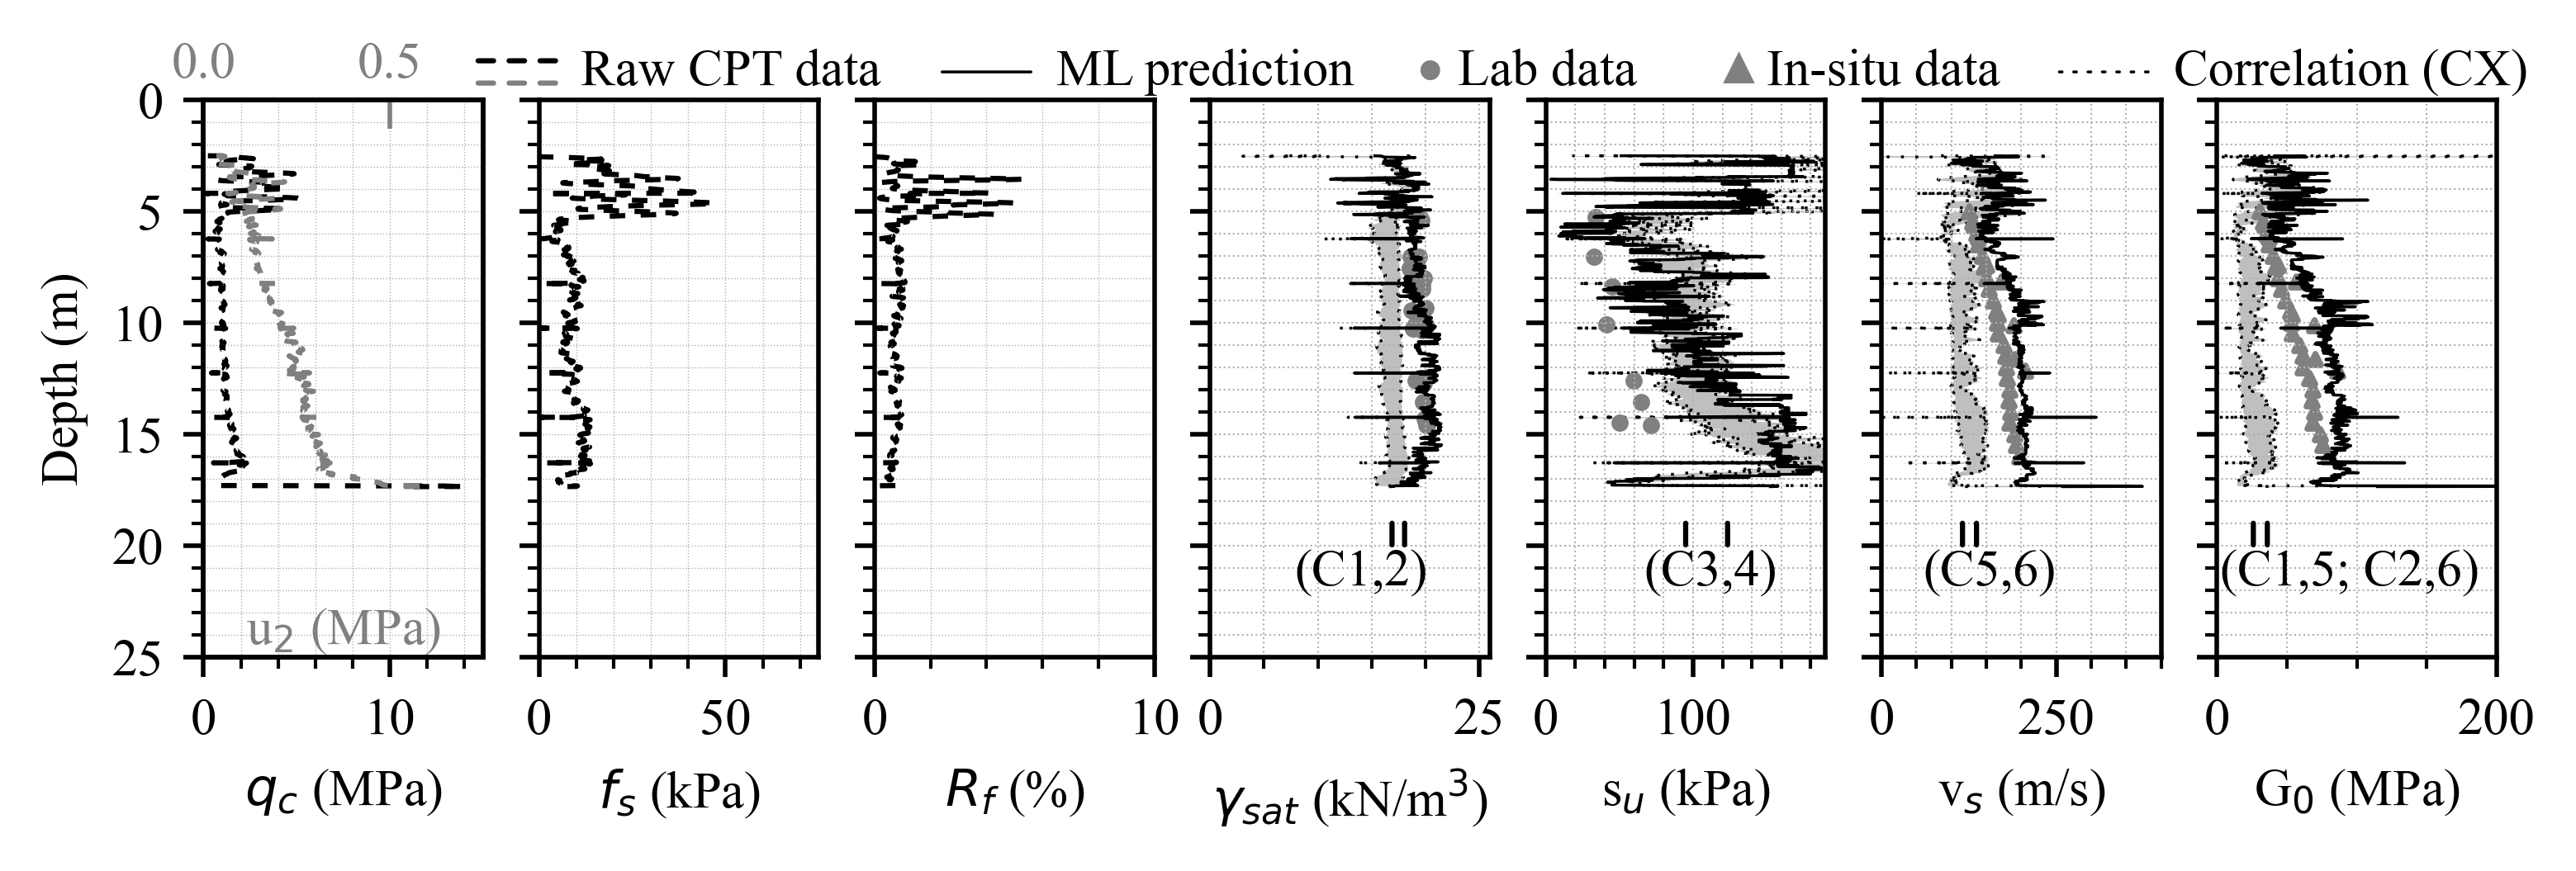

In [11]:
cm = 1/2.54  # centimeters in inches
fig, axes = plot_test_sites((15.5*cm, 4.9*cm), 7, df_test_norway_set, plot_columns_x_label)

ax_upper = axes[0].twiny()  # Create a secondary x-axis on the first subplot
ax_upper.plot(u2, df_test_norway_set['Depth (m)'].values, marker='o', color='gray', linestyle = (0, (3, 3)), linewidth=0.9, markersize=0.0)
ax_upper.set_xlabel('u$_2$ (MPa)', fontsize=9, labelpad=-105, color = 'gray')  # Label for the upper x-axis
ax_upper.set_xlim([0,0.75])  # Adjust limits as needed
ax_upper.tick_params(axis='x', which='both', direction='in', length=5, labelsize=9, colors='gray', pad=2)  # 'colors' controls ticks and tick labels


labels = ['Mayne (2006)', 'Hegazy and Mayne (1995)', 'Hegazy and Mayne (2006)']

plot_annotate_fill(axes[-1], vs_2**2*gamma_lb/9.81/1000, vs_10**2*gamma_t_rc/9.81/1000, z, x_start=0.18, y_start=0.151, 
                   y_line=0.03, spacing=0.50, l=0.08, offset=0.17, text_l='(C1,5; C2,6)', offset_line=-0.05)

plot_annotate_fill(axes[-2], vs_2, vs_10, z, x_start=0.30, y_start=0.151, 
                   y_line=0.03, spacing=0.5, l=0.08, offset=0.15, text_l='(C5,6)', offset_line=-0.01)

plot_annotate_fill(axes[-3], su_1*1000, su_2*1000, z, x_start=0.5, y_start=0.151, 
                   y_line=0.03, spacing=1.5, l=0.08, offset=0.15, text_l='(C3,4)', offset_line=0.0)

plot_annotate_fill(axes[-4], gamma_lb, gamma_t_rc, z, x_start=0.45, y_start=0.151, 
                   y_line=0.03, spacing=0.45, l=0.08, offset=0.15, text_l='(C1,2)', offset_line=0.2)    



plot_columns = ['$\gamma_{sat}$ (kN/m$^3$)', 's$_u$ (kPa)','v$_s$ (m/s)', 'G$_0$ (MPa)']

j = 0
for i in pred_df.columns:
    axes[3+j].plot(pred_df[i].values,
                df_test_norway_set['Depth (m)'].values,
                label='ML output',
                color='k', linewidth = 0.5, markersize=0.0, linestyle='solid')
    
    axes[3+j].set_xlabel(plot_columns[j])
    axes[3+j].grid(True, which='both', linestyle = 'dotted', linewidth = 0.3)

    axes[3+j].minorticks_on()
    axes[3+j].invert_yaxis()
    axes[3+j].set_xlim(xmin=0)
    j += 1

#G0 plot
axes[-1].plot((pred_df[pred_df.columns[-1]].values)**2 * (pred_df[pred_df.columns[0]].values)/9.81/1000,
                df_test_norway_set['Depth (m)'].values,
                label='ML output',
                color='k', linewidth = 0.5, markersize=0.0, linestyle='solid')
                
axes[-1].minorticks_on()
axes[-1].set_xlim(xmin=0)
axes[-1].set_xlabel(plot_columns[-1])
axes[-1].grid(True, which='both', linestyle = 'dotted', linewidth = 0.3)
axes[-1].scatter(df_lab_tests.loc[:,'SDMT'], df_lab_tests.loc[:,'Depth_SDMT'], label='Raw data', marker='^', color='gray', s=4)
axes[-1].scatter(df_lab_tests.loc[:,'V17'], df_lab_tests.loc[:,'Depth_17'], label='Raw data', marker='^', color='gray', s=4)
# axes[-1].scatter(df_lab_tests.loc[:,'V16'], df_lab_tests.loc[:,'Depth_16'], label='Raw data', marker='^', color='gray', s=4)
# axes[-1].scatter(df_lab_tests.loc[:,'V14'], df_lab_tests.loc[:,'Depth_14'], label='Raw data', marker='^', color='gray', s=4)

#shear wave velocity 
axes[-2].plot(df_vs.iloc[:,-1].values, df_vs.iloc[:,0].values, label='Raw data', marker='^', color='gray', linewidth = 0.2, markersize=0.8)
axes[-2].scatter(df_lab_tests.loc[:,'SDMT_vs'], df_lab_tests.loc[:,'Depth_SDMT'], label='Raw data', marker='^', color='gray', s=4)
axes[-2].scatter(df_lab_tests.loc[:,'17_vs'], df_lab_tests.loc[:,'Depth_17'], label='Raw data', marker='^', color='gray', s=4)
# axes[-2].scatter(df_lab_tests.loc[:,'16_vs'], df_lab_tests.loc[:,'Depth_16'], label='Raw data', marker='^', color='gray', s=4)
# axes[-2].scatter(df_lab_tests.loc[:,'14_vs'], df_lab_tests.loc[:,'Depth_14'], label='Raw data', marker='^', color='gray', s=4)

#unit weight
axes[-4].scatter(df_lab_tests.iloc[:,1].values, df_lab_tests.iloc[:,0].values, label='Raw data', marker='o', color='gray', s = 4)

#undrained shear strength
axes[-3].scatter(df_lab_tests.loc[:,'CAUC'], df_lab_tests.loc[:,'Depth_CAUC'], label='Raw data', marker='o', color='gray', s=4)
axes[-3].scatter(df_lab_tests.loc[:,'DSS'], df_lab_tests.loc[:,'Depth_DSS'], label='Raw data', marker='o', color='gray', s=4)

axes[-7].set_xlim(xmin=0, xmax=15)
axes[-6].set_xlim(xmin=0, xmax=75)
axes[-5].set_xlim(xmin=0, xmax=10)

axes[-4].set_xlim(xmin=0, xmax=26)
axes[-3].set_xlim(xmin=0, xmax=190)
axes[-2].set_xlim(xmin=0, xmax=400)
axes[-1].set_xlim(xmin=0, xmax=200)

labels = ['Raw CPT data', 'ML prediction', 'Lab data', 'In-situ data', 'Correlation (CX)']

x = -6.3
offset = 1.7
y = 1.05

axes[-1].annotate('', xy=(x, y+0.02), xytext=(x+0.4, y+0.02), arrowprops=dict(arrowstyle='-', linestyle=(0, (3, 3)), linewidth=0.9, color='k'), xycoords='axes fraction')
axes[-1].annotate('', xy=(x, y-0.02), xytext=(x+0.4, y-0.02), arrowprops=dict(arrowstyle='-', linestyle=(0, (3, 3)), linewidth=0.9, color='gray'), xycoords='axes fraction')
axes[-1].text(x+0.45, y, labels[0], color='k', ha='left', va='center', rotation=0, transform=axes[-1].transAxes)

x = x + offset
axes[-1].annotate('', xy=(x, y), xytext=(x+0.4, y), arrowprops=dict(arrowstyle='-', linestyle='solid', linewidth=0.5, color='k'), xycoords='axes fraction')
axes[-1].text(x+0.45, y, labels[1], color='k', ha='left', va='center', rotation=0, transform=axes[-1].transAxes)

x = x + offset*1.05
axes[-1].text(x, y, '●', fontsize=8, color='gray', ha='center', va='center', transform=axes[-1].transAxes)
axes[-1].text(x+0.1, y, labels[2], color='k', ha='left', va='center', rotation=0, transform=axes[-1].transAxes)

x = x + offset*0.65
axes[-1].text(x, y, '▲', fontsize=8, color='gray', ha='center', va='center', transform=axes[-1].transAxes)
axes[-1].text(x+0.1, y, labels[3], color='k', ha='left', va='center', rotation=0, transform=axes[-1].transAxes)

x = x + offset*0.65
axes[-1].annotate('', xy=(x, y), xytext=(x+0.4, y), arrowprops=dict(arrowstyle='-', linestyle=(0, (1, 4)), linewidth=0.5, color='k'), xycoords='axes fraction')
axes[-1].text(x+0.45, y, labels[4], color='k', ha='left', va='center', rotation=0, transform=axes[-1].transAxes)

fig.subplots_adjust(right=0.98, top = 0.92, bottom = 0.22, left = 0.07)
plt.savefig(save_path, dpi = 1000)